# Collect Data

In [9]:
# Collect relevant tweets through the Twitter API.
import json
import requests
import tweepy as tw

In [10]:
# IMPORTANT: enter proper access credential in config_twitter_v2api.py file
import config_twitter_v2api as config_twitter

In [11]:
# Establish the Twitter v2 API connection, respecting the rate limit
api = tw.Client(bearer_token=config_twitter.bearer_token, wait_on_rate_limit=True)
api


In [12]:
# construct a search query
query = 'ebike OR "electric bike" OR "electric bicycle" -is:retweet lang:en'

In [43]:
# decide how many tweets to query
###TODO increase this value later to collect a good dataset (try 10000 for instance)
ntweets = 200
#ntweets = 10000

In [44]:
# collect recent tweets and convert to json
fields_sel = ['id', 'created_at', 'text', 'author_id', 'public_metrics']
tweets_resp = tw.Paginator(api.search_recent_tweets, query=query, tweet_fields=fields_sel,
                           max_results=100).flatten(limit=ntweets)
tweets = [t.data for t in tweets_resp]
len(tweets)

200

In [45]:
# example tweet content (json structure)
tweets[0]

{'text': 'RT @_Dermatologist: Switched to an eBike (Brompton) for the commute. Mind blowing. 9.6km in 27mins. Average heart rate 106 (my resting is 5…',
 'author_id': '315720360',
 'created_at': '2022-07-26T18:15:11.000Z',
 'id': '1551994554760531968',
 'public_metrics': {'retweet_count': 10,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0}}

In [46]:
# save tweets data to json file
file_out = f"raw_tweet_data_{ntweets}.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(tweets, indent=2))

# Data Analysis

In [47]:
# Twitter data analysis task starter.
import html
import json
import string
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
# First collect the data in json-file; specify file name here (adjust the number as queried)
##fjson = 'raw_tweet_data_200.json'
fjson = 'raw_tweet_data_200.json'

In [49]:
# read json file with tweets data
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)

200

In [50]:
# tweet data record example: as documented for the Twitter API
# https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet
data[0]

{'text': 'RT @_Dermatologist: Switched to an eBike (Brompton) for the commute. Mind blowing. 9.6km in 27mins. Average heart rate 106 (my resting is 5…',
 'author_id': '315720360',
 'created_at': '2022-07-26T18:15:11.000Z',
 'id': '1551994554760531968',
 'public_metrics': {'retweet_count': 10,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0}}

In [51]:
# create pandas dataframe from tweet text content
# https://stackoverflow.com/a/43175477
df_tweets = pd.DataFrame([t['text'] for t in data], columns=['text'])
df_tweets

,text
0,RT @_Dermatologist: Switched to an eBike (Brom...
1,RT @_Dermatologist: Switched to an eBike (Brom...
2,RT @BoschGlobal: 🚵 Whether you're a beginner o...
3,@kogasyuto I have another ebike a rad wagon th...
4,I measured how much electricity it took to cha...
...,...
195,"@b0b0VK Nope, not an electric bike"
196,"On its way soon - look out for mobile jobs, co..."
197,"Folany Bicycle Speed Motor kit, 24V 250W Elect..."
198,Swiss man takes a world tour on solar powered ...


In [52]:
# add selected columns from tweet data fields
df_tweets['retweets'] = [t['public_metrics']['retweet_count'] for t in data]
df_tweets['favorites'] = [t['public_metrics']['like_count'] for t in data]
df_tweets['user'] = [t['author_id'] for t in data]
df_tweets

,text,retweets,favorites,user
0,RT @_Dermatologist: Switched to an eBike (Brom...,10,0,315720360
1,RT @_Dermatologist: Switched to an eBike (Brom...,10,0,19499325
2,RT @BoschGlobal: 🚵 Whether you're a beginner o...,74,0,2176040712
3,@kogasyuto I have another ebike a rad wagon th...,0,0,3805762513
4,I measured how much electricity it took to cha...,0,0,252938837
...,...,...,...,...
195,"@b0b0VK Nope, not an electric bike",0,1,1461448568
196,"On its way soon - look out for mobile jobs, co...",0,2,1194722809307697153
197,"Folany Bicycle Speed Motor kit, 24V 250W Elect...",0,0,1543873945878790144
198,Swiss man takes a world tour on solar powered ...,0,0,141764283


In [53]:
# text cleaning function: see prior class modules
stop_words = set(stopwords.words('english'))

# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [54]:
# add clean text column
# NOTE: apply in pandas applies a function to each element of the selected column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
df_tweets['text_clean'] = df_tweets['text'].apply(text_cleanup)
df_tweets

,text,retweets,favorites,user,text_clean
0,RT @_Dermatologist: Switched to an eBike (Brom...,10,0,315720360,rt switched ebike brompton commute mind blowin...
1,RT @_Dermatologist: Switched to an eBike (Brom...,10,0,19499325,rt switched ebike brompton commute mind blowin...
2,RT @BoschGlobal: 🚵 Whether you're a beginner o...,74,0,2176040712,rt boschglobal whether beginner experienced mo...
3,@kogasyuto I have another ebike a rad wagon th...,0,0,3805762513,kogasyuto another ebike rad wagon janet last f...
4,I measured how much electricity it took to cha...,0,0,252938837,measured much electricity took charge electric...
...,...,...,...,...,...
195,"@b0b0VK Nope, not an electric bike",0,1,1461448568,b0b0vk nope electric bike
196,"On its way soon - look out for mobile jobs, co...",0,2,1194722809307697153,way soon look mobile jobs collection delivery ...
197,"Folany Bicycle Speed Motor kit, 24V 250W Elect...",0,0,1543873945878790144,folany bicycle speed motor kit 24v 250w electr...
198,Swiss man takes a world tour on solar powered ...,0,0,141764283,swiss man takes world tour solar powered elect...


In [55]:
# sentiment analysis
def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

df_tweets['polarity'] = df_tweets['text_clean'].apply(sentim_polarity)
df_tweets['subjectivity'] = df_tweets['text_clean'].apply(sentim_subject)
df_tweets

,text,retweets,favorites,user,text_clean,polarity,subjectivity
0,RT @_Dermatologist: Switched to an eBike (Brom...,10,0,315720360,rt switched ebike brompton commute mind blowin...,-0.150,0.400000
1,RT @_Dermatologist: Switched to an eBike (Brom...,10,0,19499325,rt switched ebike brompton commute mind blowin...,-0.150,0.400000
2,RT @BoschGlobal: 🚵 Whether you're a beginner o...,74,0,2176040712,rt boschglobal whether beginner experienced mo...,0.400,0.475000
3,@kogasyuto I have another ebike a rad wagon th...,0,0,3805762513,kogasyuto another ebike rad wagon janet last f...,0.175,0.266667
4,I measured how much electricity it took to cha...,0,0,252938837,measured much electricity took charge electric...,0.200,0.200000
...,...,...,...,...,...,...,...
195,"@b0b0VK Nope, not an electric bike",0,1,1461448568,b0b0vk nope electric bike,0.000,0.000000
196,"On its way soon - look out for mobile jobs, co...",0,2,1194722809307697153,way soon look mobile jobs collection delivery ...,0.000,0.000000
197,"Folany Bicycle Speed Motor kit, 24V 250W Elect...",0,0,1543873945878790144,folany bicycle speed motor kit 24v 250w electr...,0.100,0.350000
198,Swiss man takes a world tour on solar powered ...,0,0,141764283,swiss man takes world tour solar powered elect...,0.000,0.000000


In [56]:
# define the list of brands to analyze, consistent with the search topic
#  for which the tweets were collected
brands = ['bosch', 'yamaha', 'shimano', 'trek', 'rad', 'aventon', 'specialized']

In [57]:
# start a brand comparison dataframe
df_brands = pd.DataFrame(brands, columns=['brand'])
df_brands

,brand
0,bosch
1,yamaha
2,shimano
3,trek
4,rad
5,aventon
6,specialized


In [58]:
# example: tweet subset mentioning a given brand
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html
df_tweets[df_tweets['text_clean'].str.contains("bosch")]

,text,retweets,favorites,user,text_clean,polarity,subjectivity
2,RT @BoschGlobal: 🚵 Whether you're a beginner o...,74,0,2176040712,rt boschglobal whether beginner experienced mo...,0.400000,0.475000
21,RT @BoschGlobal: 🏙️🚴‍♀️ At last week's @EUROBI...,49,0,1456983067848019976,rt boschglobal last week presented new ebike a...,0.045455,0.473737
36,RT @BoschGlobal: 🚵 Whether you're a beginner o...,74,0,1150064251945406464,rt boschglobal whether beginner experienced mo...,0.400000,0.475000
41,RT @BoschGlobal: 🏙️🚴‍♀️ At last week's @EUROBI...,49,0,1491126437281251332,rt boschglobal last week presented new ebike a...,0.045455,0.473737
74,RT @BoschGlobal: 🚵 Whether you're a beginner o...,74,0,621779182,rt boschglobal whether beginner experienced mo...,0.400000,0.475000
118,RT @BoschGlobal: 🏙️🚴‍♀️ At last week's @EUROBI...,49,0,1502840017898868736,rt boschglobal last week presented new ebike a...,0.045455,0.473737
166,RT @BoschGlobal: 🚵 Whether you're a beginner o...,74,0,1312680596594810881,rt boschglobal whether beginner experienced mo...,0.400000,0.475000
192,"Bosch Cycling eBike Battery Pin Cover, Black [...",0,0,1546506914422562823,bosch cycling ebike battery pin cover black m1...,-0.166667,0.433333
193,Happy customer with her brand new Cube Kathman...,0,2,1240207393398587392,happy customer brand new cube kathmandu hybrid...,0.468182,0.727273


In [59]:
# function to compute average sentiment of tweets mentioning a given brand
def brand_sentiment(b):
    return df_tweets[df_tweets['text_clean'].str.contains(b)]['polarity'].mean()

In [60]:
# brand sentiment comparison
df_brands['average_sentiment'] = df_brands['brand'].apply(brand_sentiment)
df_brands

,brand,average_sentiment
0,bosch,0.226431
1,yamaha,0.000000
2,shimano,NaN
3,trek,NaN
4,rad,0.067562
5,aventon,0.196875
6,specialized,0.400000


In [61]:
# highest sentiment tweets
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
df_tweets.sort_values(by='polarity', ascending=False).head(10)

,text,retweets,favorites,user,text_clean,polarity,subjectivity
105,#SINCH / Foldable #Ebike\nBest Electric Bicycl...,0,1,1476742116,sinch foldable ebike best electric bicycles on...,1.00,0.30
148,RT @EwingLesley: Driving is just so soul-deade...,1,0,222358903,rt ewinglesley driving delivery goods win nece...,0.80,0.40
151,Help me win an Electric Fatbike from https://t...,0,1,16908732,help win electric fatbike,0.80,0.40
113,"RT @PA4CBJ: Support the #Voices""FORE""ALZ golf ...",0,0,3090484493,rt pa4cbj support voices fore alz golf outing ...,0.80,0.40
40,RT @BikeDeansgrange: Great to see more electri...,1,0,733578483054477312,rt bikedeansgrange great see electric bike sha...,0.80,0.75
90,Help me win an Electric Fatbike from https://t...,0,0,1101962680296984578,help win electric fatbike,0.80,0.40
178,Help me win an Electric Fatbike from https://t...,0,0,1287261720,help win electric fatbike,0.80,0.40
53,Top 7 Best Hurley Electric Bike https://t.co/4...,0,0,1309528665361973249,top 7 best hurley electricbike,0.75,0.40
52,RT @EdinReporter: @AlexHynes @kim_harding @Sco...,2,0,1513454816,rt edinreporter alexhynes scotrail transcotlan...,0.70,0.60
136,Mozo front-suspension forks – any good for e-b...,0,0,1220998532418551812,mozo forks good endlesssphere,0.70,0.60


In [62]:
# most retweeted content
df_tweets.sort_values(by='retweets', ascending=False).head(10)

,text,retweets,favorites,user,text_clean,polarity,subjectivity
2,RT @BoschGlobal: 🚵 Whether you're a beginner o...,74,0,2176040712,rt boschglobal whether beginner experienced mo...,0.400000,0.475000
74,RT @BoschGlobal: 🚵 Whether you're a beginner o...,74,0,621779182,rt boschglobal whether beginner experienced mo...,0.400000,0.475000
36,RT @BoschGlobal: 🚵 Whether you're a beginner o...,74,0,1150064251945406464,rt boschglobal whether beginner experienced mo...,0.400000,0.475000
166,RT @BoschGlobal: 🚵 Whether you're a beginner o...,74,0,1312680596594810881,rt boschglobal whether beginner experienced mo...,0.400000,0.475000
21,RT @BoschGlobal: 🏙️🚴‍♀️ At last week's @EUROBI...,49,0,1456983067848019976,rt boschglobal last week presented new ebike a...,0.045455,0.473737
41,RT @BoschGlobal: 🏙️🚴‍♀️ At last week's @EUROBI...,49,0,1491126437281251332,rt boschglobal last week presented new ebike a...,0.045455,0.473737
118,RT @BoschGlobal: 🏙️🚴‍♀️ At last week's @EUROBI...,49,0,1502840017898868736,rt boschglobal last week presented new ebike a...,0.045455,0.473737
114,RT @mistress_marnie: Yesterday my wallet sprun...,29,0,1551106711456555011,rt yesterday wallet sprung 300 want buy ebike ...,-0.100000,0.075000
0,RT @_Dermatologist: Switched to an eBike (Brom...,10,0,315720360,rt switched ebike brompton commute mind blowin...,-0.150000,0.400000
50,RT @_Dermatologist: Switched to an eBike (Brom...,10,0,109531988,rt switched ebike brompton commute mind blowin...,-0.150000,0.400000


In [67]:

# users producing most retweeted content
df_tweets.sort_values(by='retweets', ascending=False).head(10)['user']
## look up user details with userid:
## https://twitter.com/i/user/{usrid}

2               2176040712
74               621779182
36     1150064251945406464
166    1312680596594810881
21     1456983067848019976
41     1491126437281251332
118    1502840017898868736
114    1551106711456555011
0                315720360
50               109531988
Name: user, dtype: object

In [77]:
# combine all text for a specific brand
def brand_all_text(b):
    # https://stackoverflow.com/a/51871650
    return ' '.join(df_tweets[df_tweets['text_clean'].str.contains(b)]['text_clean'])

In [78]:
brand_all_text('specialized')

'friday evolution bikes partnership specialized bicycles hosting free electric bike experience day iach dwyfor leasure centre pwllheli register 45 minute test ride electric bikes'

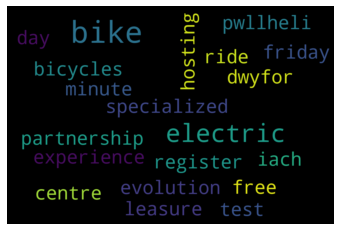

In [79]:
# most common twet content keywords for a specific brand
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
b = 'specialized'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()